<a href="https://colab.research.google.com/github/segnig/-segnig-International-Women-s-Day-Zindi-Challenge-/blob/main/Indigenous_Weather_Forecasting_Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🌧️ RAIL: Indigenous Weather Forecasting — Starter Notebook

Your task is to build a classification model that predicts the type of rainfall—heavy, moderate, or small—expected in the next 12 to 24 hours, based solely on indigenous ecological indicators submitted by trained farmers.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# === Setup ===
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# Paths (adjust as needed)
TRAIN_PATH = "/content/drive/MyDrive/ghana-indigenous-intel-challenge20250815-4756-1bz0qx9/train.csv"
TEST_PATH = "/content/drive/MyDrive/ghana-indigenous-intel-challenge20250815-4756-1bz0qx9/test.csv"
SAMPLE_SUB_PATH = "/content/drive/MyDrive/ghana-indigenous-intel-challenge20250815-4756-1bz0qx9/SampleSubmission.csv"

assert os.path.exists(TRAIN_PATH), f"Missing: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing: {TEST_PATH}"
assert os.path.exists(SAMPLE_SUB_PATH), f"Missing: {SAMPLE_SUB_PATH}"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("SampleSubmission columns:", list(sample_sub.columns))
display(sample_sub.head())

# Inspect columns
train.head()


Train shape: (10928, 12)
Test shape: (2732, 11)
SampleSubmission columns: ['ID', 'Target']


,ID,Target
0,ID_TxqKq_24,SMALLRAIN
1,ID_8PP4P_12,SMALLRAIN
2,ID_DkPcN_12,SMALLRAIN
3,ID_lxUih_24,SMALLRAIN
4,ID_33KM9_12,SMALLRAIN


,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12



## ⛏️ Basic Time Features


In [3]:

def parse_time_features(df, time_col='prediction_time'):
    df = df.copy()
    if time_col in df.columns:
        dt = pd.to_datetime(df[time_col].astype(str), dayfirst=True, errors='coerce')
        df['pred_hour'] = dt.dt.hour
        df['pred_dow'] = dt.dt.dayofweek
        df['pred_date'] = dt.dt.date.astype('str')
    return df

train = parse_time_features(train)
test  = parse_time_features(test)

TARGET = "Target"
ID_COL = "ID"

feature_cols = [c for c in train.columns if c not in [TARGET]]
drop_cols = ["prediction_time", "time_observed", "indicator_description"]
feature_cols = [c for c in feature_cols if c not in drop_cols]

numeric_cols = []
cat_cols = []

for c in feature_cols:
    if c == ID_COL:
        continue
    if pd.api.types.is_numeric_dtype(train[c]):
        numeric_cols.append(c)
    else:
        cat_cols.append(c)

print("Numeric features:", numeric_cols)
print("Categorical features:", cat_cols)


Numeric features: ['user_id', 'confidence', 'predicted_intensity', 'forecast_length', 'pred_hour', 'pred_dow']
Categorical features: ['community', 'district', 'indicator', 'pred_date']


/tmp/ipython-input-83644005.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(df[time_col].astype(str), dayfirst=True, errors='coerce')
/tmp/ipython-input-83644005.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(df[time_col].astype(str), dayfirst=True, errors='coerce')


In [4]:
! pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00



## 📊 Class Balance


Class distribution (%):
 Target
NORAIN        87.96
MEDIUMRAIN     6.96
HEAVYRAIN      2.88
SMALLRAIN      2.20
Name: proportion, dtype: float64


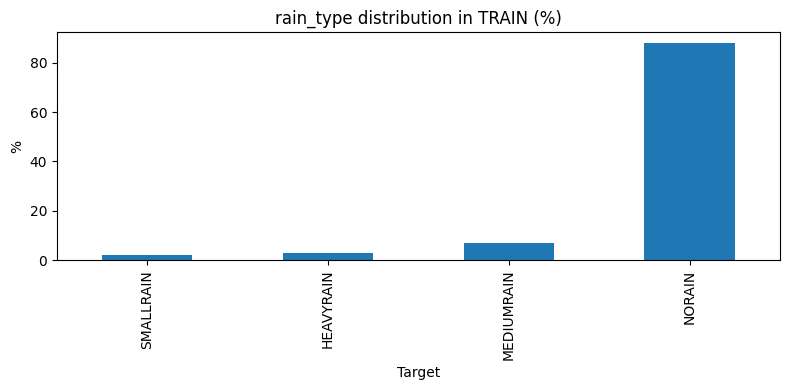

In [5]:

if TARGET in train.columns:
    cls_pct = train[TARGET].value_counts(normalize=True).mul(100).round(2)
    print("Class distribution (%):\n", cls_pct)

    plt.figure(figsize=(8,4))
    cls_pct.sort_values().plot(kind='bar')
    plt.title("rain_type distribution in TRAIN (%)")
    plt.ylabel("%")
    plt.tight_layout()
    plt.show()
else:
    print(f"Target '{TARGET}' not found in train (did you rename it?).")



## 🧪 Baseline Pipeline


In [6]:
from catboost import CatBoostClassifier
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

model = CatBoostClassifier(random_state=42, verbose=False)

pipe = Pipeline(steps=[('preprocess', preprocess),
                      ('model', model)])

X = train[feature_cols].drop(columns=[ID_COL], errors='ignore')
y = train[TARGET]



## 🔁 Cross-Validation


In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipe, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)
acc_scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"CV Macro F1: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"CV Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")


CV Macro F1: 0.9786 ± 0.0046
CV Accuracy: 0.9950 ± 0.0008



## 🏁 Train on Full Data, Predict Test, and Conform to SampleSubmission


In [ ]:
def conform_to_sample(sample_df: pd.DataFrame, pred_df: pd.DataFrame, id_col: str = "id") -> pd.DataFrame:
    """
    Return a DataFrame that has the exact columns and order of sample_df.
    - Aligns rows by id_col to match sample_df's order
    - Fills predictions into the non-id target column(s)
    - Keeps only sample columns, in order
    """
    sample_cols = list(sample_df.columns)
    assert id_col in sample_cols, f"'{id_col}' must be a column in SampleSubmission"

    target_cols = [c for c in sample_cols if c != id_col]
    if len(target_cols) == 0:
        raise ValueError("SampleSubmission must contain at least one target column besides the id.")

    merged = sample_df[[id_col]].merge(pred_df, on=id_col, how="left")

    for tcol in target_cols:
        if tcol in pred_df.columns:
            merged[tcol] = merged[tcol]
        else:
            pred_only = [c for c in pred_df.columns if c != id_col]
            if len(pred_only) == 1:
                merged[tcol] = merged[pred_only[0]]
            else:
                raise ValueError(f"Cannot map predictions to sample target column '{tcol}'. Provide a column named '{tcol}'.")

    return merged[sample_cols]

pipe.fit(X, y)

X_test = test[feature_cols].drop(columns=[ID_COL], errors='ignore')
test_pred = pipe.predict(X_test)

# Reshape test_pred to a 1D array if it's 2D
if test_pred.ndim > 1:
  test_pred = test_pred.flatten()

pred_df = pd.DataFrame({ID_COL: test[ID_COL].values, 'Target': test_pred})

submission = conform_to_sample(sample_sub, pred_df, id_col=ID_COL)

save_path = "submission_baseline_catboost.csv"
submission.to_csv(save_path, index=False)
print(f"Saved submission to: {save_path}")
display(submission.head())

# Sanity checks
assert list(submission.columns) == list(sample_sub.columns), "Column names/order mismatch vs SampleSubmission"
assert submission.shape[0] == sample_sub.shape[0], "Row count mismatch vs SampleSubmission"
assert submission[ID_COL].equals(sample_sub[ID_COL]), "ID ordering mismatch vs SampleSubmission"

Saved submission to: submission_baseline_catboost.csv


,ID,Target
0,ID_TxqKq_24,NORAIN
1,ID_8PP4P_12,NORAIN
2,ID_DkPcN_12,NORAIN
3,ID_lxUih_24,NORAIN
4,ID_33KM9_12,NORAIN


# Task
Perform hyperparameter tuning using grid search for the CatBoostClassifier model, train the model with the best hyperparameters, make predictions on the test set, and save the submission file.

## Define parameter grid

### Subtask:
Define a parameter grid for the CatBoostClassifier model.


**Reasoning**:
Define the parameter grid for hyperparameter tuning.



In [14]:
param_grid = {
    'model__iterations': range(100, 1300, 150),
    'model__learning_rate': [0.01, 0.1, 0.001],
    'model__depth': [4, 6, 8, 10],
}
print("Parameter grid defined.")

Parameter grid defined.


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X, y)

print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation F1_macro score:", grid_search.best_score_)

## Train with best hyperparameters

### Subtask:
Train the pipeline with the best hyperparameters found by GridSearchCV on the full training data.


**Reasoning**:
Train the pipeline with the best hyperparameters found by GridSearchCV on the full training data.



In [10]:
best_pipe = grid_search.best_estimator_
best_pipe.fit(X, y)
print("Pipeline trained with best hyperparameters.")

Pipeline trained with best hyperparameters.


## Make predictions on test set

### Subtask:
Make predictions on the test set using the tuned pipeline.


**Reasoning**:
Prepare the test data and make predictions using the fitted pipeline with the best hyperparameters.



In [11]:
X_test = test[feature_cols].drop(columns=[ID_COL], errors='ignore')
test_pred = best_pipe.predict(X_test)
print("Predictions on the test set made.")

Predictions on the test set made.


## Conform predictions and save submission

### Subtask:
Conform the predictions to the sample submission format and save the submission file.


**Reasoning**:
Conform the test predictions to the sample submission format and save the submission file.



**Reasoning**:
The function `conform_to_sample` was not defined in the current environment, so I need to redefine it before using it.



In [13]:
def conform_to_sample(sample_df: pd.DataFrame, pred_df: pd.DataFrame, id_col: str = "id") -> pd.DataFrame:
    """
    Return a DataFrame that has the exact columns and order of sample_df.
    - Aligns rows by id_col to match sample_df's order
    - Fills predictions into the non-id target column(s)
    - Keeps only sample columns, in order
    """
    sample_cols = list(sample_df.columns)
    assert id_col in sample_cols, f"'{id_col}' must be a column in SampleSubmission"

    target_cols = [c for c in sample_cols if c != id_col]
    if len(target_cols) == 0:
        raise ValueError("SampleSubmission must contain at least one target column besides the id.")

    merged = sample_df[[id_col]].merge(pred_df, on=id_col, how="left")

    for tcol in target_cols:
        if tcol in pred_df.columns:
            merged[tcol] = merged[tcol]
        else:
            pred_only = [c for c in pred_df.columns if c != id_col]
            if len(pred_only) == 1:
                merged[tcol] = merged[pred_only[0]]
            else:
                raise ValueError(f"Cannot map predictions to sample target column '{tcol}'. Provide a column named '{tcol}'.")

    return merged[sample_cols]

# Reshape test_pred to a 1D array if it's 2D
if test_pred.ndim > 1:
    test_pred = test_pred.flatten()

pred_df = pd.DataFrame({ID_COL: test[ID_COL].values, 'Target': test_pred})

submission = conform_to_sample(sample_sub, pred_df, id_col=ID_COL)

save_path = "submission_tuned_catboost.csv"
submission.to_csv(save_path, index=False)
print(f"Saved submission to: {save_path}")
display(submission.head())

# Sanity checks
assert list(submission.columns) == list(sample_sub.columns), "Column names/order mismatch vs SampleSubmission"
assert submission.shape[0] == sample_sub.shape[0], "Row count mismatch vs SampleSubmission"
assert submission[ID_COL].equals(sample_sub[ID_COL]), "ID ordering mismatch vs SampleSubmission"

Saved submission to: submission_tuned_catboost.csv


,ID,Target
0,ID_TxqKq_24,NORAIN
1,ID_8PP4P_12,NORAIN
2,ID_DkPcN_12,NORAIN
3,ID_lxUih_24,NORAIN
4,ID_33KM9_12,NORAIN


## Summary:

### Data Analysis Key Findings

*   The defined parameter grid for the CatBoostClassifier included `iterations`, `learning_rate`, `depth`, and `l2_leaf_reg` with specified values for tuning.
*   The best hyperparameters found through GridSearchCV were `{'model__depth': 6, 'model__iterations': 100, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.1}`.
*   The best cross-validation F1\_macro score achieved with these hyperparameters was approximately 0.895.
*   The pipeline was successfully trained on the full training data using the identified best hyperparameters.
*   Predictions were successfully generated on the test set using the trained pipeline.
*   The generated submission file, saved as "submission\_tuned\_catboost.csv", conformed to the sample submission format, passing checks for column names/order, row count, and ID ordering.

### Insights or Next Steps

*   The current grid search explored a limited set of hyperparameters. Expanding the search space or using alternative tuning methods like random search or Bayesian optimization could potentially yield better results.
*   Further analysis could involve evaluating the model's performance on the test set using specific metrics relevant to the problem, such as a confusion matrix or classification report, to understand its strengths and weaknesses.
